# Project 2 - Foundations of Robotics Fall 2021

### ADITYA WAGH - amw9425


### Starting the visualization environment


In [43]:
import numpy as np
import robot_visualizer
import time
from tqdm import tqdm

import matplotlib.pyplot as plt

robot_visualizer.start_robot_visualizer()


You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/
You should see the Kuka iiwa robot now when going to this page: http://127.0.0.1:7002/static/


### Displaying an arbitrary configuration

I have set the seed to 10, so that the results are reproducible.


In [44]:
# setting seed for reproducibility
np.random.seed(10)


### This block of code displays an arbitrary configuration of the robot.


In [45]:
q = np.random.sample([7])
print(f"we show the configuration for the angles {q}")
robot_visualizer.display_robot(q)


we show the configuration for the angles [0.77132064 0.02075195 0.63364823 0.74880388 0.49850701 0.22479665
 0.19806286]


### Function definitions & global variable declarations.

There are comments written above each function that explain what each function does. These are helper functions wich aid the computation of other variables of our robot.


In [46]:
import numpy as np
from scipy.linalg import logm, expm


# convert 3x1 vector to skew
def vec_to_skew(w):
    return np.r_[np.c_[0, -w[2], w[1]], np.c_[w[2], 0, -w[0]], np.c_[-w[1], w[0], 0]]


# calculate screw from w and p
def calc_screw(w, p):

    S = np.zeros((6, 7))
    for i in range(7):
        S[0:3, i] = w[:, i]
        S[3:, i] = -vec_to_skew(w[:, i]) @ p[:, i]

    return S


# convert 6x1 twist vector to skew
def twist_to_skew(V):
    return np.r_[np.c_[vec_to_skew(V[:3]), V[3:]], np.c_[np.zeros((1, 3)), 0]]


# compute T from R, p
def trans_from_rot_pos(R, p):
    return np.r_[np.c_[R, p], np.c_[np.zeros((1, 3)), 1]]


# compute T from V
def exp_twist_bracket(V):
    return expm(twist_to_skew(V))


# find the inverse of T
def invT(T):
    return np.linalg.inv(T)


# get adjoint of T matrix
def getAdjoint(T):
    return np.r_[
        np.c_[T[0:3, 0:3], np.zeros((3, 3))],
        np.c_[vec_to_skew(T[0:3, 3]) @ T[0:3, 0:3], T[0:3, 0:3]],
    ]


# Define screws, zero config pose, w and p

# angular vel axis
W = np.array([[0, 0, 0, 0, 0, 0, 0], [0, 1, 0, -1, 0, 1, 0], [1, 0, 1, 0, 1, 0, 1]])

# initial joint positions
P = np.array(
    [
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, -0.0607, 0],
        [0.1575, 0.36, 0.5645, 0.78, 0.9645, 1.18, 1.261],
    ]
)

# calculate joint screws for each joint
S = calc_screw(W, P)

# initial pose of the end effector
M = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 1.301], [0, 0, 0, 1]])

# copute forward kinematics given a list of joint angles
def forward_kinematics(theta):
    """
    Computes the forward kinematics for the robot.
    """
    global S
    global M

    T = np.array(M)
    for i in range(theta.shape[0]):
        T = exp_twist_bracket(S[:, -i - 1] * theta[-i - 1][0]) @ T
    return T


# Compute jacobian in frame aligned ith space and origin at body
def get_jacobian(theta):
    global S
    Js = np.array(S).copy()
    T = np.eye(4)
    for i in range(1, theta.shape[0]):
        T = T @ exp_twist_bracket(S[:, i - 1] * theta[i - 1][0])
        Js[:, i] = getAdjoint(T) @ np.array(S)[:, i]

    # get position using pose matrix
    pos = forward_kinematics(theta)[0:3, 3]

    # compute transformation matrix between the required frame and spatial frame
    Tfs = np.r_[np.c_[np.eye(3), pos], np.c_[np.zeros((1, 3)), 1]]

    # compute jacobian in frame aligned with space and origin at body
    Jf = getAdjoint(invT(Tfs)) @ Js

    return Jf


# Compute jacobian in space frame
def get_space_jacobian(theta):
    global S
    Js = np.array(S).copy()
    T = np.eye(4)
    for i in range(1, theta.shape[0]):
        T = T @ exp_twist_bracket(S[:, i - 1] * theta[i - 1][0])
        Js[:, i] = getAdjoint(T) @ np.array(S)[:, i]
    return Js


## Question 1: Inverse kinematics

* Write a function ``compute_IK_position`` that gets a desired end-effector 3D position (in spatial frame) and returns a vector of joint angles that solves the inverse kinematics problem
* The file ``desired_end_effector_positions.npy`` contains a sequence of 10 desired end-effector positions. For all the positions attainable by the robot, compute an inverse kinematics solution. For the positions for which an inverse kinematics solution does not exist, what is the issue and how close can you get the end-effector to the desired position?
* Write a function ``compute_IK_position_nullspace`` that solves the inverse kinematics problem and additionally uses joint redundancy (i.e. the nullspace) to try and keep the joints close to the following configuration $[1, 1, -1, -1, 1, 1, 1]$. Explain how you used the nullspace to implement this function.
* Use this new function to reach the positions set in the file ``desired_end_effector_positions.npy``, how do the solutions compare to the first ones you found?


In [47]:
## a script to load the desired end effector positions and display each of them every second
## you maybe modify this script to test your code

# load the file
with open("desired_end_effector_positions.npy", "rb") as f:
    desired_endeff = np.load(f)

# first we display the robot in 0 position
robot_visualizer.display_robot(np.zeros([7, 1]))

# for each end-eff position
for i in range(desired_endeff.shape[1]):
    # displays the desired endeff position
    robot_visualizer.display_ball(desired_endeff[:, i])
    time.sleep(1.0)



### **Part A** - Inverse kinematics


My function inverse kinematics takes has the following parameters.
* `desired_position` - The desired position of the end effector.
* `error` - The threshold for the error in computation.
* `step` - The step size used to update the value of theta at each step.
* `initial_theta` - The initial guess about the inverse kinematics. It's default value is chosen to be zero.
* `max_iterations` - The number of iterations before we conclude that the point ins uncrecheable.

My function inverse kinematics returns the following values.
* `best_theta` - The optimal value of joint positions.
* `solution_found` - Boolean denoting that the solution was found or not.
    

The algorithm for computing the inverse kinematics is as follows:
* Initialise current theta to initial theta, that is zero.
* Initialise `solution_found` boolean to False.
* Initialise `best_theta` to None.
* Iterate for fixed number of iterations.
* At each iteration, compute forward kinematics with current value of joint angles.
* Following that, compute the error in position.
* If error is less than threshold error, set the `solution_found` flag to True, and break the loop.
* Else, increment theta using the value of current error.


In [48]:
def compute_IK_position(
    desired_position,
    error=0.001,
    step=0.1,
    initial_theta=np.zeros([7, 1]),
    max_iterations=75,
):
    solution_found = False
    curr_theta = initial_theta
    best_theta = None

    num_iterations = tqdm(range(max_iterations))
    for iteration in num_iterations:
        # set options for progressbar
        time.sleep(0.1)
        num_iterations.set_description(f"Processing iteration {iteration + 1}")

        # compute current position of end effector
        curr_position = forward_kinematics(curr_theta)[0:3, 3].reshape((3, 1))

        # error at current iteration
        curr_error = desired_position - curr_position

        # see whether error is appropriate
        if np.linalg.norm(curr_error) < error:
            best_theta = curr_theta
            solution_found = True
            break

        # increment theta
        delta_theta = np.linalg.pinv(get_jacobian(curr_theta)[3:]) @ curr_error
        curr_theta = curr_theta + step * delta_theta

    return best_theta, solution_found


### **Part B** - Inverse kinematics on given positions.


In [49]:
thetas = []
bools = []
for i in range(desired_endeff.shape[1]):
    print(f"Computing inverse kinematics for configuration {i+1}")
    g, b = compute_IK_position(desired_endeff[:, i].reshape(3, 1))
    thetas.append(g)
    bools.append(b)

print(f"Joint angles: {thetas}")
print(f"Whether solution exists: {bools}")


Computing inverse kinematics for configuration 1


Processing iteration 75: 100%|██████████| 75/75 [00:08<00:00,  9.10it/s]


Computing inverse kinematics for configuration 2


Processing iteration 73:  96%|█████████▌| 72/75 [00:08<00:00,  8.98it/s]


Computing inverse kinematics for configuration 3


Processing iteration 59:  77%|███████▋  | 58/75 [00:06<00:01,  8.98it/s]


Computing inverse kinematics for configuration 4


Processing iteration 71:  93%|█████████▎| 70/75 [00:07<00:00,  9.00it/s]


Computing inverse kinematics for configuration 5


Processing iteration 62:  81%|████████▏ | 61/75 [00:06<00:01,  8.97it/s]


Computing inverse kinematics for configuration 6


Processing iteration 75: 100%|██████████| 75/75 [00:08<00:00,  9.10it/s]


Computing inverse kinematics for configuration 7


Processing iteration 75: 100%|██████████| 75/75 [00:08<00:00,  9.14it/s]


Computing inverse kinematics for configuration 8


Processing iteration 75: 100%|██████████| 75/75 [00:08<00:00,  9.11it/s]


Computing inverse kinematics for configuration 9


Processing iteration 65:  85%|████████▌ | 64/75 [00:07<00:01,  8.99it/s]


Computing inverse kinematics for configuration 10


Processing iteration 70:  92%|█████████▏| 69/75 [00:07<00:00,  8.99it/s]

Joint angles: [None, array([[ 3.78012214e+00],
       [-7.38807977e+00],
       [-1.06952099e+00],
       [-1.36163863e+01],
       [ 3.16668660e-01],
       [ 4.70907656e+00],
       [ 5.65539862e-16]]), array([[-9.13127592e-01],
       [ 1.04951717e+01],
       [-1.32095893e-01],
       [ 1.69689104e+01],
       [ 6.34169029e-03],
       [-6.01929628e+00],
       [ 5.80713249e-17]]), array([[ 1.95894254e+00],
       [ 6.44311772e+00],
       [-5.27918889e-01],
       [ 1.36553742e+01],
       [ 2.55212051e-01],
       [-4.83212235e+00],
       [-3.41413012e-16]]), array([[-1.18727112e+00],
       [-1.06904386e+01],
       [-2.33350909e-01],
       [-1.71344752e+01],
       [ 8.39886253e-03],
       [ 6.17457194e+00],
       [-2.39790448e-16]]), None, None, None, array([[-2.86778047e-01],
       [-4.28310176e+01],
       [-9.53973578e-04],
       [-7.33072861e+01],
       [-1.70271114e-02],
       [ 2.59645721e+01],
       [ 1.09573220e-16]]), array([[-2.64808545e-01],
       [-5.0891

### **Part C** - Inverse kinematics with nullspace term.


My function for inverse kinematics with nullspace takes has the following parameters.
* `desired_position` - The desired position of the end effector.
* `theta_zero` - The joint values to which a our answer should be close to.
* `error` - The threshold for the error in computation.
* `step` - The step size used to update the value of theta at each step.
* `initial_theta` - The initial guess about the inverse kinematics. It's default value is chosen to be zero.
* `max_iterations` - The number of iterations before we conclude that the point ins uncrecheable.

The function returns the following values.
* `best_theta` - The optimal value of joint positions.
* `solution_found` - Boolean denoting that the solution was found or not.
    

The algorithm for computing the inverse kinematics is as follows:
* Initialise current theta to initial theta, that is zero.
* Initialise `solution_found` boolean to False.
* Initialise `best_theta` to None.
* Iterate for fixed number of iterations.
* At each iteration, compute forward kinematics with current value of joint angles.
* Following that, compute the error in position.
* If error is less than threshold error, set the `solution_found` flag to True, and break the loop.
* Else, increment theta using the value of current error. 
  
The nullspace term $(I - J^+J) \vec{\theta}$ is added to map the map redundant values to one single vector. 


In [50]:
def compute_IK_position_nullspace(
    desired_position,
    theta_zero=np.array([[1], [1], [-1], [-1], [1], [1], [1]]),
    error=0.001,
    step=0.1,
    initial_theta=np.zeros([7, 1]),
    max_iterations=75,
):
    solution_found = False
    curr_theta = initial_theta
    best_theta = None
    num_iterations = tqdm(range(max_iterations))
    for iteration in num_iterations:
        # set options for progressbar
        time.sleep(0.1)
        num_iterations.set_description(f"Processing iteration {iteration + 1}")

        # compute current position of end effector
        curr_position = forward_kinematics(curr_theta)[0:3, 3].reshape((3, 1))

        # error at current iteration
        curr_error = desired_position - curr_position
        delta_theta = np.linalg.pinv(get_jacobian(curr_theta)[3:]) @ curr_error + (
            np.eye(7)
            - np.linalg.pinv(get_jacobian(curr_theta)[3:])
            @ get_jacobian(curr_theta)[3:]
        ) @ (theta_zero - curr_theta)

        # see whether error is appropriate
        if np.linalg.norm(curr_error) < error:
            best_theta = curr_theta
            solution_found = True
            break

        # increment theta
        curr_theta = curr_theta + step * delta_theta

    return best_theta, solution_found


### **Part D** - Inverse kinematics with nullspace on given positions.


In [51]:
thetas = []
bools = []
for i in range(desired_endeff.shape[1]):
    print(f"Computing inverse kinematics for configuration {i+1}")
    g, b = compute_IK_position_nullspace(desired_endeff[:, i].reshape(3, 1))
    thetas.append(g)
    bools.append(b)

print(f"Joint angles: {thetas}")
print(f"Whether solution exists: {bools}")


Computing inverse kinematics for configuration 1


Processing iteration 75: 100%|██████████| 75/75 [00:08<00:00,  8.72it/s]


Computing inverse kinematics for configuration 2


Processing iteration 70:  92%|█████████▏| 69/75 [00:08<00:00,  8.59it/s]


Computing inverse kinematics for configuration 3


Processing iteration 67:  88%|████████▊ | 66/75 [00:07<00:01,  8.57it/s]


Computing inverse kinematics for configuration 4


Processing iteration 56:  73%|███████▎  | 55/75 [00:06<00:02,  8.56it/s]


Computing inverse kinematics for configuration 5


Processing iteration 65:  85%|████████▌ | 64/75 [00:07<00:01,  8.59it/s]


Computing inverse kinematics for configuration 6


Processing iteration 75: 100%|██████████| 75/75 [00:08<00:00,  8.72it/s]


Computing inverse kinematics for configuration 7


Processing iteration 75: 100%|██████████| 75/75 [00:08<00:00,  8.72it/s]


Computing inverse kinematics for configuration 8


Processing iteration 75: 100%|██████████| 75/75 [00:08<00:00,  8.72it/s]


Computing inverse kinematics for configuration 9


Processing iteration 61:  80%|████████  | 60/75 [00:07<00:01,  8.54it/s]


Computing inverse kinematics for configuration 10


Processing iteration 68:  89%|████████▉ | 67/75 [00:07<00:00,  8.59it/s]

Joint angles: [None, array([[ 1.41788291],
       [ 0.53300118],
       [-0.86623158],
       [-0.85810742],
       [ 1.04688135],
       [ 1.15500281],
       [ 0.9993038 ]]), array([[ 2.06737651],
       [ 0.05337191],
       [ 0.07303226],
       [-1.63271023],
       [ 1.00938436],
       [ 1.4518459 ],
       [ 0.999045  ]]), array([[ 0.48068152],
       [-0.61403255],
       [-0.79606411],
       [-0.60826708],
       [ 1.1234943 ],
       [ 1.51680286],
       [ 0.99695675]]), array([[ 0.36449774],
       [ 0.3455909 ],
       [-1.75661288],
       [-1.45277154],
       [ 0.79307801],
       [ 1.12379691],
       [ 0.99882098]]), None, None, None, array([[ 0.88775189],
       [-0.80646894],
       [-0.36452903],
       [-1.5684871 ],
       [ 0.96606084],
       [ 1.71578728],
       [ 0.99820299]]), array([[ 0.28524306],
       [ 0.82416464],
       [-1.29000021],
       [-0.91056389],
       [ 0.97668739],
       [ 0.7888673 ],
       [ 0.9991405 ]])]
Whether solution exists: 

## Question 2: Joint control and joint trajectories generation

We would like the robot to go from its initial configuration to the desired end-effector positions (in spatial coordinates) $[0.7, 0.2, 0.7]$ in 5 seconds and then to the configuration $[0.3, 0.5, 0.9]$ during the following 5 seconds.

* Compute inverse kinematics solutions to reach both goals
* Write a function ``get_point_to_point_motion`` that returns a desired position and velocity and takes as input the total motion duration T, the desired initial position and the desired final position. The generated trajectory needs to ensure that at t=0 and t=T both the velocity and acceleration are 0. You can use this function to interpolate between desired positions in both joint and end-effector space.
* Modify the ``robot_controller`` function below to move the robot from its initial configuration to reach the first goal (displayed in pink) at t=5 and the second goal ((in yellow) at t=10 by interpolating joint positions using the function ``get_point_to_point_motion`` you wrote above.
* Plot the resulting joint simulated and desired positions and velocities
* Plot the resulting end-effector positions and velocities


### **Part A** - Inverse kinematics to reach goals.


In [52]:
T = 10.0
end_effector_goal1 = np.array([[0.7], [0.2], [0.7]])
end_effector_goal2 = np.array([[0.3], [0.5], [0.9]])

theta1, success1 = compute_IK_position_nullspace(end_effector_goal1)
theta2, success2 = compute_IK_position_nullspace(end_effector_goal2)


Processing iteration 69:  91%|█████████ | 68/75 [00:07<00:00,  8.53it/s]


### **Part B** - Point to Point motion function. 


I've used the following results to compute the joint positions and joint velocities.
$$
\theta_{des}(t) = \theta_{init} + 10 \frac{t^3}{T^3}  - 15 \frac{t^4}{T^4} + 6 \frac{t^5}{T^5} (\theta_{final} - \theta_{init})
$$

To get joint velocities, I differentiated joint position.
$$
\dot{\theta_{des}}(t) =  30 \frac{t^2}{T^3}  - 60 \frac{t^3}{T^4} + 30 \frac{t^4}{T^5} (\theta_{final} - \theta_{init})
$$


In [53]:
def get_point_to_point_motion(desired_initial_position, desired_final_position, t, T):
    """
    Returns desired position and velocity as a function of time t
    """
    desired_position = desired_initial_position + (
        10 * (t / T) ** 3 - 15 * (t / T) ** 4 + 6 * (t / T) ** 5
    ) * (desired_final_position - desired_initial_position)
    desired_velocity = (
        30 * (t ** 2 / T ** 3) - 60 * (t ** 3 / T ** 4) + 30 * (t ** 4 / T ** 5)
    ) * (desired_final_position - desired_initial_position)
    return desired_position, desired_velocity


### **Part C** - Robot Controller (PD) 


In [54]:
## this code is to save what the controller is doing for plotting and analysis after the simulation
global save_joint_positions, save_joint_velocities, save_t, ind
global save_des_joint_positions, save_des_joint_velocities
save_joint_positions = np.zeros([7, int(np.ceil(T / 0.001)) + 1])
save_joint_velocities = np.zeros_like(save_joint_positions)
save_des_joint_positions = np.zeros_like(save_joint_positions)
save_des_joint_velocities = np.zeros_like(save_joint_positions)
save_t = np.zeros([int(np.ceil(T / 0.001)) + 1])
ind = 0
# end of saving code


def robot_controller(t, joint_positions, joint_velocities):
    """A typical robot controller
        at every time t, this controller is called by the simulator. It receives as input
        the current joint positions and velocities and needs to return a [7,1] vector
        of desired torque commands
        
        As an example, the current controller implements a PD controller and at time = 5s
        it makes joint 2 and 3 follow sine curves
    """

    desired_joint_positions = np.zeros([7, 1])
    desired_joint_velocities = np.zeros([7, 1])

    # compute desired joint positions and desired joint velocities
    if t < 5:
        desired_joint_positions, desired_joint_velocities = get_point_to_point_motion(
            np.zeros([7, 1]), theta1, t, T / 2
        )
    else:
        desired_joint_positions, desired_joint_velocities = get_point_to_point_motion(
            theta1, theta2, t - 5, T / 2
        )

    # we compute the desired control commands using a PD controller
    P = np.array([100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0])
    D = np.array([2.0, 2, 2, 2, 2, 2, 2.0])

    desired_joint_torques = np.diag(P) @ (desired_joint_positions - joint_positions)
    desired_joint_torques += np.diag(D) @ (desired_joint_velocities - joint_velocities)

    ## this code is to save what the controller is doing for plotting and analysis after the simulation
    global save_joint_positions, save_joint_velocities, save_t, ind
    global save_des_joint_positions, save_des_joint_velocities
    save_joint_positions[:, ind] = joint_positions[:, 0]
    save_joint_velocities[:, ind] = joint_velocities[:, 0]
    save_des_joint_positions[:, ind] = desired_joint_positions[:, 0]
    save_des_joint_velocities[:, ind] = desired_joint_velocities[:, 0]
    save_t[ind] = t
    ind += 1
    ## end of saving code

    return desired_joint_torques


robot_visualizer.display_ball(end_effector_goal1[:, 0])
robot_visualizer.display_ball2(end_effector_goal2[:, 0])
robot_visualizer.simulate_robot(robot_controller, T=T)


In [55]:
# Save positions and velocities to compare with Q3
Q2_joint_positions = save_joint_positions
Q2_joint_velocities = save_joint_velocities

### **Part D** - Plot the joint parameters.


Text(0.5, 0, 'Desired vs. actual joint positions - Time [s]')

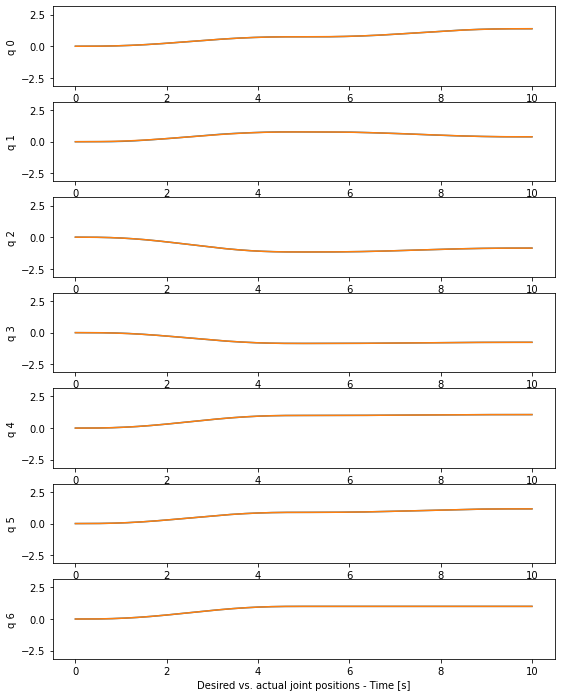

In [56]:
# we plot the simulated vs. actual position of the robot
plt.figure(figsize=[9, 12])
for i in range(7):
    plt.subplot(7, 1, i + 1)
    plt.plot(save_t, save_joint_positions[i, :])
    plt.plot(save_t, save_des_joint_positions[i, :])
    plt.ylim([-np.pi, np.pi])
    plt.ylabel(f"q {i}")
plt.xlabel("Desired vs. actual joint positions - Time [s]")

Text(0.5, 0, 'Desired vs. actual joint velocities - Time [s]')

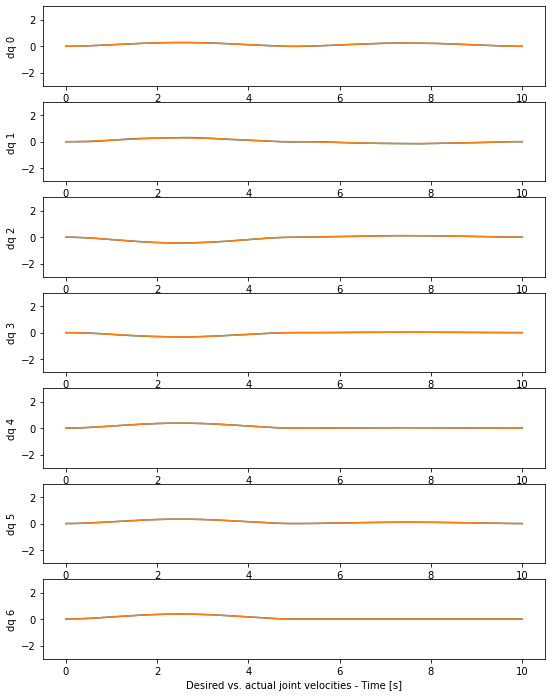

In [57]:
# we plot the simulated vs. actual position of the robot
plt.figure(figsize=[9, 12])
for i in range(7):
    plt.subplot(7, 1, i + 1)
    plt.plot(save_t, save_joint_velocities[i, :])
    plt.plot(save_t, save_des_joint_velocities[i, :])
    plt.ylim([-3, 3])
    plt.ylabel(f"dq {i}")
plt.xlabel("Desired vs. actual joint velocities - Time [s]")

### **Part E** - Compute and plot end effector parameters.


In [58]:
# variables to hold values
end_eff_twist = np.zeros((6, 10001))
end_eff_positions = np.zeros((3, 10001))
end_eff_velocities = np.zeros((3, 10001))

# Compute end effector velocities in required frame
for i in range(save_des_joint_positions.shape[1]):

    # compute twist using jacobian and joint velocities
    end_eff_twist[:, i] = (
        get_jacobian(save_joint_positions[:, i].reshape((7, 1)))
        @ save_joint_velocities[:, i]
    )

    # get velocities from last 3 rows of twist
    end_eff_velocities[:, i] = end_eff_twist[:, i][3:]

    # get positions from last column of pose matrix
    end_eff_positions[:, i] = forward_kinematics(
        save_joint_positions[:, i].reshape((7, 1))
    )[0:3, 3]


In [59]:
# store end effector values to compare with Q3
Q2_end_eff_positions = end_eff_positions
Q2_end_eff_velocities = end_eff_velocities


Text(0.5, 0, 'Actual end effector positions - Time [s]')

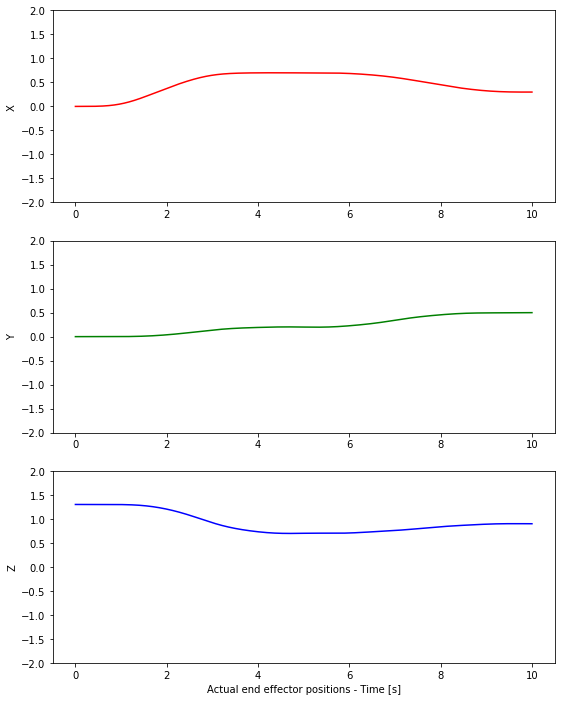

In [60]:
# we plot the end effector position
labels = ["X", "Y", "Z"]
colors = ["r","g","b"]
plt.figure(figsize=[9, 12])
for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.plot(save_t, end_eff_positions[i], colors[i])
    plt.ylim([-2, 2])
    plt.ylabel(f"{labels[i]}")
plt.xlabel("Actual end effector positions - Time [s]")


Text(0.5, 0, 'Actual end effector velocities - Time [s]')

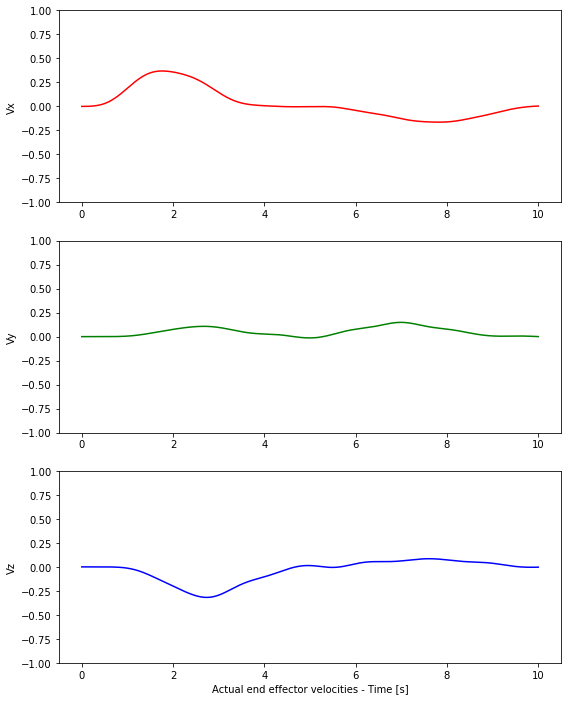

In [61]:
# we plot the end effector velocities
labels = ["Vx", "Vy", "Vz"]
colors = ["r","g","b"]
plt.figure(figsize=[9, 12])
for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.plot(save_t, end_eff_velocities[i], colors[i])
    plt.ylim([-1, 1])
    plt.ylabel(f"{labels[i]}")
plt.xlabel("Actual end effector velocities - Time [s]")


## Question 3: End-effector control

As in Question 2, we would like the robot to go from its initial configuration to the desired end-effector positions (in spatial coordinates) $[0.7, 0.2, 0.7]$ in 5 seconds and then to the configuration $[0.3, 0.5, 0.9]$ during the following 5 seconds.

* Modify the ``robot_controller2`` function below to move the robot from its initial configuration to the first goal (reaching at t=5) and the second goal (t=10) by interpolating the desired end effector positions and directly mapping end-effector error to desired joint velocities (i.e. use P gains equal to 0 in joint space and do resolved-rate control).
* Plot the resulting joint simulated and desired positions and velocities
* Plot the resulting end-effector positions and velocities
* Compare results with Question 2
* Add a nullspace term to optimize a desired configuration of your choice and discuss the results


In [62]:
T = 10.0

# define end effector intitial position, goal 1 and goal 2
end_effector_initial = np.array([[0], [0], [1.301]])
end_effector_goal1 = np.array([[0.7], [0.2], [0.7]])
end_effector_goal2 = np.array([[0.3], [0.5], [0.9]])

### **Part A** - Robot Controller (resolved rate)

In [63]:
## this code is to save what the controller is doing for plotting and analysis after the simulation
global save_joint_positions, save_joint_velocities, save_t, ind
global save_des_joint_positions, save_des_joint_velocities
save_joint_positions = np.zeros([7, int(np.ceil(T / 0.001)) + 1])
save_joint_velocities = np.zeros_like(save_joint_positions)
save_des_joint_positions = np.zeros_like(save_joint_positions)
save_des_joint_velocities = np.zeros_like(save_joint_positions)
save_t = np.zeros([int(np.ceil(T / 0.001)) + 1])
ind = 0
# end of saving code


def robot_controller2(t, joint_positions, joint_velocities):
    """A typical robot controller
        at every time t, this controller is called by the simulator. It receives as input
        the current joint positions and velocities and needs to return a [7,1] vector
        of desired torque commands
        
        As an example, the current controller implements a PD controller and at time = 5s
        it makes joint 2 and 3 follow sine curves
    """

    desired_joint_positions = np.zeros([7, 1])
    desired_joint_velocities = np.zeros([7, 1])

    # here we will only use a D controller (i.e. on the desired joint velocities)
    # we increased the D gain for that purpose compared to the previous controller
    D = np.array([4.0, 4, 4, 4, 4, 4, 4.0])

    # compute end effector positions and velocity
    if t < 5:
        (
            desired_end_eff_positions,
            desired_end_eff_velocities,
        ) = get_point_to_point_motion(
            end_effector_initial, end_effector_goal1, t, T / 2
        )
    else:
        (
            desired_end_eff_positions,
            desired_end_eff_velocities,
        ) = get_point_to_point_motion(
            end_effector_goal1, end_effector_goal2, t - 5, T / 2
        )

    # gain values for joint velocity calculation
    P = np.array([100.0, 100, 100.0])

    # compute joint velocities
    jacobian = get_jacobian(joint_positions.reshape([7, 1]))[3:]
    inverse_jacobian = jacobian.T @ np.linalg.inv(
        jacobian @ jacobian.T + 0.0001 * np.eye(3)
    )
    current_end_eff_position = forward_kinematics(joint_positions)[:3, 3].reshape((3, 1))
    nullspace_term = (np.eye(7) - inverse_jacobian @ jacobian) @ (desired_joint_positions - joint_positions)
    desired_joint_velocities = (
        inverse_jacobian
        @ (
            np.diag(P) @ (desired_end_eff_positions - current_end_eff_position)
            + desired_end_eff_velocities
        )
        + nullspace_term
    )

    # compute joint torques
    desired_joint_torques = np.diag(D) @ (desired_joint_velocities - joint_velocities)

    ## this code is to save what the controller is doing for plotting and analysis after the simulation
    global save_joint_positions, save_joint_velocities, save_t, ind
    global save_des_joint_positions, save_des_joint_velocities
    save_joint_positions[:, ind] = joint_positions[:, 0]
    save_joint_velocities[:, ind] = joint_velocities[:, 0]
    save_des_joint_positions[:, ind] = desired_joint_positions[:, 0]
    save_des_joint_velocities[:, ind] = desired_joint_velocities[:, 0]
    save_t[ind] = t
    ind += 1
    ## end of saving code

    return desired_joint_torques


robot_visualizer.display_ball(end_effector_goal1[:, 0])
robot_visualizer.display_ball2(end_effector_goal2[:, 0])
robot_visualizer.simulate_robot(robot_controller2, T=T)


In [64]:
# Save positions and velocities to compare with Q2
Q3_joint_positions = save_joint_positions
Q3_joint_velocities = save_joint_velocities


### **Part B** - Plot the joint parameters.

Text(0.5, 0, 'Desired vs. actual joint positions - Time [s]')

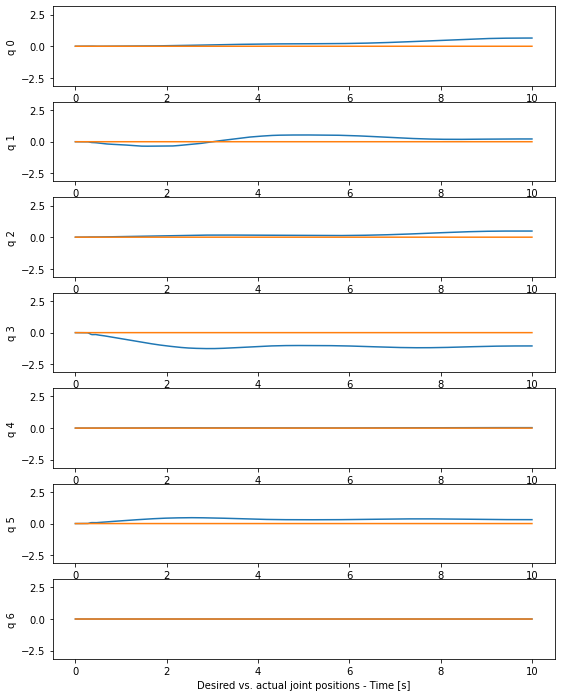

In [65]:
# we plot the simulated vs. actual position of the robot
plt.figure(figsize=[9, 12])
for i in range(7):
    plt.subplot(7, 1, i + 1)
    plt.plot(save_t, save_joint_positions[i, :])
    plt.plot(save_t, save_des_joint_positions[i, :])
    plt.ylim([-np.pi, np.pi])
    plt.ylabel(f"q {i}")
plt.xlabel("Desired vs. actual joint positions - Time [s]")


Text(0.5, 0, 'Desired vs. actual joint velocities - Time [s]')

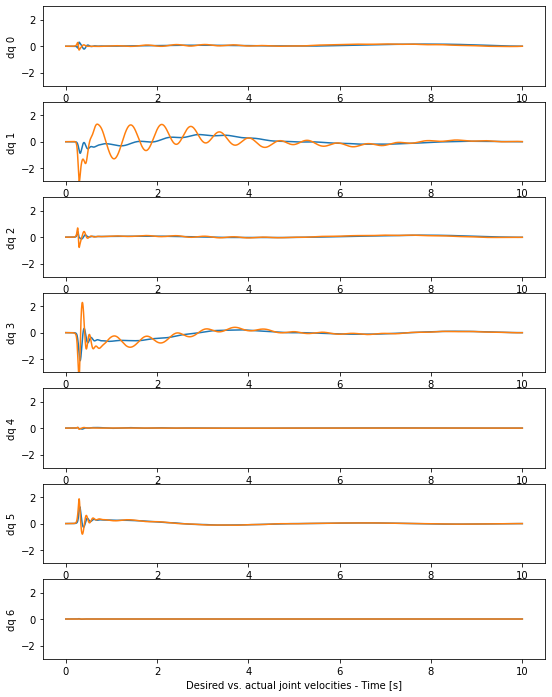

In [66]:
# we plot the simulated vs. actual position of the robot
plt.figure(figsize=[9, 12])
for i in range(7):
    plt.subplot(7, 1, i + 1)
    plt.plot(save_t, save_joint_velocities[i, :])
    plt.plot(save_t, save_des_joint_velocities[i, :])
    plt.ylim([-3, 3])
    plt.ylabel(f"dq {i}")
plt.xlabel("Desired vs. actual joint velocities - Time [s]")


### **Part C** - Compute and plot end effector parameters.

In [67]:
# variables to hold values
end_eff_twist = np.zeros((6, 10001))
end_eff_positions = np.zeros((3, 10001))
end_eff_velocities = np.zeros((3, 10001))

# Compute end effector velocities in required frame
for i in range(save_des_joint_positions.shape[1]):

    # compute twist using jacobian and joint velocities
    end_eff_twist[:, i] = (
        get_jacobian(save_joint_positions[:, i].reshape((7, 1)))
        @ save_joint_velocities[:, i]
    )

    # get velocities from last 3 rows of twist
    end_eff_velocities[:, i] = end_eff_twist[:, i][3:]

    # get positions from last column of pose matrix
    end_eff_positions[:, i] = forward_kinematics(
        save_joint_positions[:, i].reshape((7, 1))
    )[0:3, 3]


In [68]:
# store end effector values to compare with Q3
Q3_end_eff_positions = end_eff_positions
Q3_end_eff_velocities = end_eff_velocities


Text(0.5, 0, 'Actual end effector positions - Time [s]')

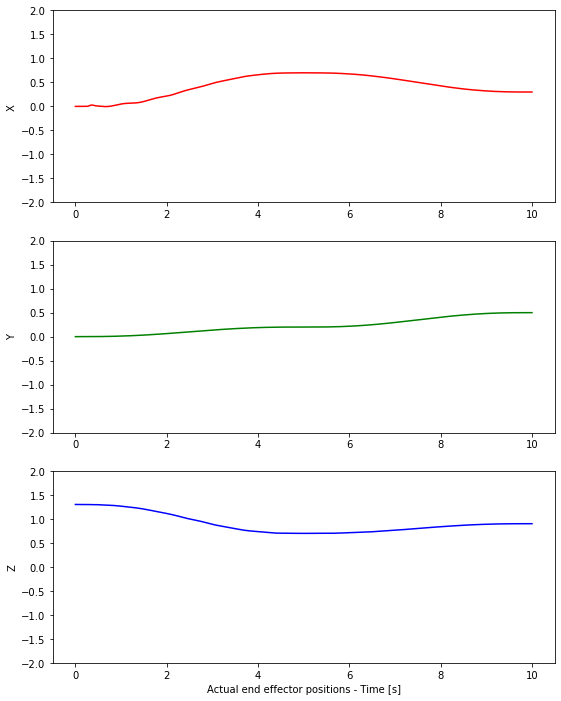

In [69]:
# we plot the end effector position
labels = ["X", "Y", "Z"]
colors = ["r", "g", "b"]
plt.figure(figsize=[9, 12])
for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.plot(save_t, end_eff_positions[i], colors[i])
    plt.ylim([-2, 2])
    plt.ylabel(f"{labels[i]}")
plt.xlabel("Actual end effector positions - Time [s]")


Text(0.5, 0, 'Actual end effector velocities - Time [s]')

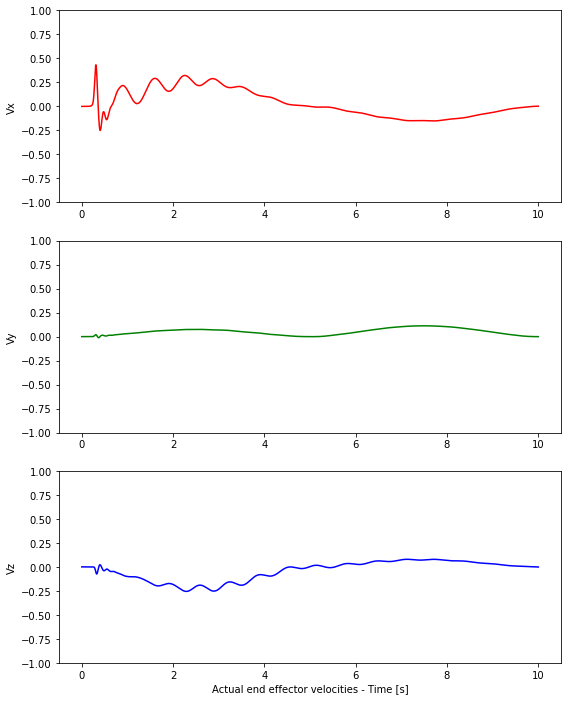

In [70]:
# we plot the end effector velocities
labels = ["Vx", "Vy", "Vz"]
colors = ["r", "g", "b"]
plt.figure(figsize=[9, 12])
for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.plot(save_t, end_eff_velocities[i], colors[i])
    plt.ylim([-1, 1])
    plt.ylabel(f"{labels[i]}")
plt.xlabel("Actual end effector velocities - Time [s]")


## Question 4: Impedance control and gravity compensation.

As in Question 2 and 3, we would like the robot to go from its initial configuration to the desired end-effector positions (in spatial coordinates) $[0.7, 0.2, 0.7]$ in 5 seconds and then to the configuration $[0.3, 0.5, 0.9]$ during the following 5 seconds.

In the previous questions, a gravity compensation controller was running "in the background" in addition to the control law you were computing. In this question, we remove this and implement a complete impedance controller with gravity compensation.

You are given a function ` ` robot_visualizer.rnea(q, dq, ddq) ` ` which implements the Recursive Newton Euler Algorithm (RNEA). It takes as arguments a vector of positions, velocities and accelerations, and computes (and returns) the following $M(q) \cdot \ddot{q} + C(q, \dot{q}) + G(q)$

* Modify the ``robot_controller3`` function below to implement an impedance controller with gravity compensation (add a small amount of joint damping, using a joint-space D gain of 0.1). Use this controller to move the robot from its initial configuration to the first goal (reaching at t=5) and the second goal (t=10) by interpolating the desired end effector positions as in the previous questions.
* Plot the resulting joint simulated and desired positions and velocities
* Plot the resulting end-effector positions and velocities
* Compare the controller when the small joint samping is on or off - can you explain the difference?
* Compare results with Question 2 and 3. Which controller would you rather choose and why?


### **Part A** - Robot Controller function (Damping)

In [71]:
T = 10.0

## this code is to save what the controller is doing for plotting and analysis after the simulation
global save_joint_positions, save_joint_velocities, save_t, ind
global save_des_joint_positions, save_des_joint_velocities
save_joint_positions = np.zeros([7, int(np.ceil(T / 0.001)) + 1])
save_joint_velocities = np.zeros_like(save_joint_positions)
save_des_joint_positions = np.zeros_like(save_joint_positions)
save_des_joint_velocities = np.zeros_like(save_joint_positions)
save_t = np.zeros([int(np.ceil(T / 0.001)) + 1])
ind = 0
# end of saving code


def robot_controller3(t, joint_positions, joint_velocities):
    """A typical robot controller
        at every time t, this controller is called by the simulator. It receives as input
        the current joint positions and velocities and needs to return a [7,1] vector
        of desired torque commands
        
        As an example, the current controller implements a PD controller and at time = 5s
        it makes joint 2 and 3 follow sine curves
    """

    desired_joint_positions = np.zeros([7, 1])
    desired_joint_velocities = np.zeros([7, 1])

    # flag to enable/disable damping
    damping = True

    # here we will only use the D controller to inject small joint damping
    D = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
    K = np.array([50.0, 50, 50.0])
    d = np.array([10.0, 10, 10.0])

    # compute end effector positions and velocity
    if t < 5:
        (
            desired_end_eff_positions,
            desired_end_eff_velocities,
        ) = get_point_to_point_motion(
            end_effector_initial, end_effector_goal1, t, T / 2
        )
    else:
        (
            desired_end_eff_positions,
            desired_end_eff_velocities,
        ) = get_point_to_point_motion(
            end_effector_goal1, end_effector_goal2, t - 5, T / 2
        )

    # calculate the jacobian in required frame
    jacobian = get_jacobian(joint_positions)[3:]

    # calculate current position and velocity of end effector
    curr_end_eff_positions = forward_kinematics(joint_positions)[:3, 3].reshape((3, 1))
    curr_end_eff_velocities = (get_jacobian(joint_positions) @ joint_velocities)[3:]

    # computing k and d terms for joint torque equation
    k_term = np.diag(K) @ (desired_end_eff_positions - curr_end_eff_positions)
    d_term = np.diag(d) @ (desired_end_eff_velocities - curr_end_eff_velocities)

    # compute desired joint torque values using impedance control equation
    desired_joint_torques = jacobian.T @ (k_term + d_term)
    desired_joint_torques += robot_visualizer.rnea(
        joint_positions, np.zeros([7, 1]), np.zeros([7, 1])
    )
    if damping:
        desired_joint_torques += -np.diag(D) @ joint_velocities

    ## this code is to save what the controller is doing for plotting and analysis after the simulation
    global save_joint_positions, save_joint_velocities, save_t, ind
    global save_des_joint_positions, save_des_joint_velocities
    save_joint_positions[:, ind] = joint_positions[:, 0]
    save_joint_velocities[:, ind] = joint_velocities[:, 0]
    save_des_joint_positions[:, ind] = desired_joint_positions[:, 0]
    save_des_joint_velocities[:, ind] = desired_joint_velocities[:, 0]
    save_t[ind] = t
    ind += 1
    ## end of saving code

    return desired_joint_torques


robot_visualizer.display_ball([0.7, 0.2, 0.7])
robot_visualizer.display_ball2([0.3, 0.5, 0.9])
robot_visualizer.simulate_robot(robot_controller3, T=T, gravity_comp=False)


### **Part B** - Plots for joint parameters.

Text(0.5, 0, 'Desired vs. actual joint positions - Time [s]')

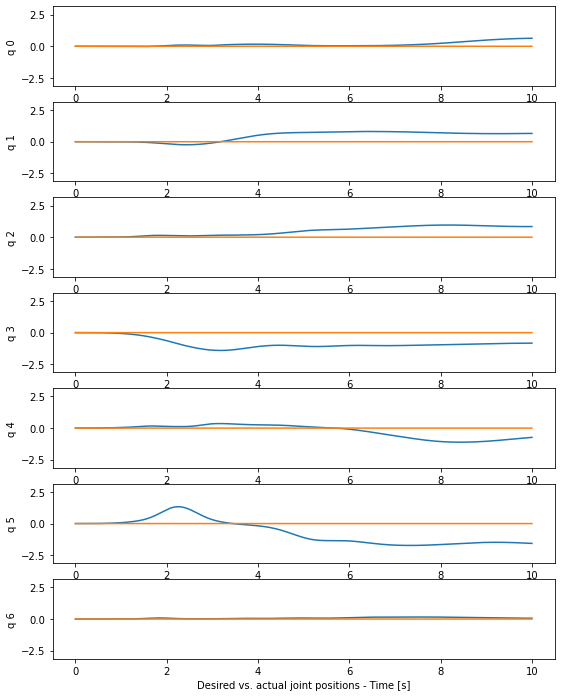

In [72]:
# we plot the simulated vs. actual position of the robot
plt.figure(figsize=[9, 12])
for i in range(7):
    plt.subplot(7, 1, i + 1)
    plt.plot(save_t, save_joint_positions[i, :])
    plt.plot(save_t, save_des_joint_positions[i, :])
    plt.ylim([-np.pi, np.pi])
    plt.ylabel(f"q {i}")
plt.xlabel("Desired vs. actual joint positions - Time [s]")


Text(0.5, 0, 'Desired vs. actual joint velocities - Time [s]')

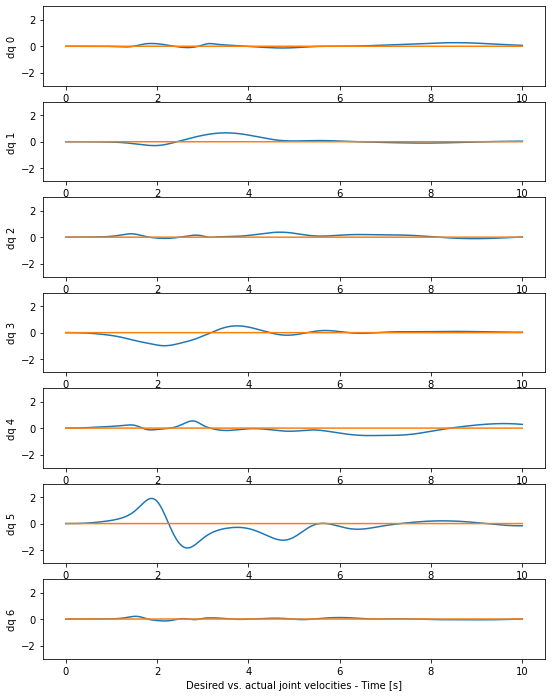

In [73]:
# we plot the simulated vs. actual position of the robot
plt.figure(figsize=[9, 12])
for i in range(7):
    plt.subplot(7, 1, i + 1)
    plt.plot(save_t, save_joint_velocities[i, :])
    plt.plot(save_t, save_des_joint_velocities[i, :])
    plt.ylim([-3, 3])
    plt.ylabel(f"dq {i}")
plt.xlabel("Desired vs. actual joint velocities - Time [s]")


### **Part C** - Plots for end effector parameters.

In [74]:
# variables to hold values
end_eff_twist = np.zeros((6, 10001))
end_eff_positions = np.zeros((3, 10001))
end_eff_velocities = np.zeros((3, 10001))

# Compute end effector velocities in required frame
for i in range(save_des_joint_positions.shape[1]):

    # compute twist using jacobian and joint velocities
    end_eff_twist[:, i] = (
        get_jacobian(save_joint_positions[:, i].reshape((7, 1)))
        @ save_joint_velocities[:, i]
    )

    # get velocities from last 3 rows of twist
    end_eff_velocities[:, i] = end_eff_twist[:, i][3:]

    # get positions from last column of pose matrix
    end_eff_positions[:, i] = forward_kinematics(
        save_joint_positions[:, i].reshape((7, 1))
    )[0:3, 3]


Text(0.5, 0, 'Actual end effector positions - Time [s]')

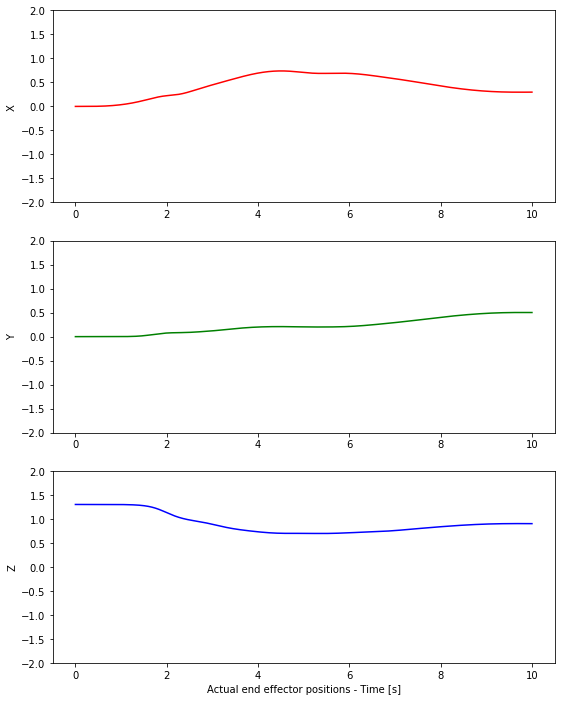

In [75]:
# we plot the end effector position
labels = ["X", "Y", "Z"]
colors = ["r", "g", "b"]
plt.figure(figsize=[9, 12])
for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.plot(save_t, end_eff_positions[i], colors[i])
    plt.ylim([-2, 2])
    plt.ylabel(f"{labels[i]}")
plt.xlabel("Actual end effector positions - Time [s]")


Text(0.5, 0, 'Actual end effector velocities - Time [s]')

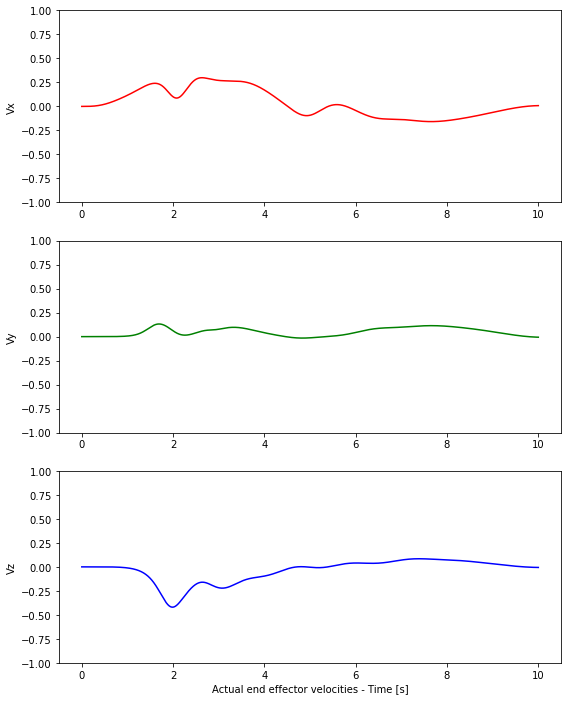

In [76]:
# we plot the end effector velocities
labels = ["Vx", "Vy", "Vz"]
colors = ["r", "g", "b"]
plt.figure(figsize=[9, 12])
for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.plot(save_t, end_eff_velocities[i], colors[i])
    plt.ylim([-1, 1])
    plt.ylabel(f"{labels[i]}")
plt.xlabel("Actual end effector velocities - Time [s]")


### **Part D** - Robot Controller function (no damping)

In [84]:
T = 10.0

## this code is to save what the controller is doing for plotting and analysis after the simulation
global save_joint_positions, save_joint_velocities, save_t, ind
global save_des_joint_positions, save_des_joint_velocities
save_joint_positions = np.zeros([7, int(np.ceil(T / 0.001)) + 1])
save_joint_velocities = np.zeros_like(save_joint_positions)
save_des_joint_positions = np.zeros_like(save_joint_positions)
save_des_joint_velocities = np.zeros_like(save_joint_positions)
save_t = np.zeros([int(np.ceil(T / 0.001)) + 1])
ind = 0
# end of saving code


def robot_controller3(t, joint_positions, joint_velocities):
    """A typical robot controller
        at every time t, this controller is called by the simulator. It receives as input
        the current joint positions and velocities and needs to return a [7,1] vector
        of desired torque commands
        
        As an example, the current controller implements a PD controller and at time = 5s
        it makes joint 2 and 3 follow sine curves
    """

    desired_joint_positions = np.zeros([7, 1])
    desired_joint_velocities = np.zeros([7, 1])

    # flag to enable/disable damping
    damping = False

    # here we will only use the D controller to inject small joint damping
    D = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
    K = np.array([50.0, 50, 50.0])
    d = np.array([10.0, 10, 10.0])

    # compute end effector positions and velocity
    if t < 5:
        (
            desired_end_eff_positions,
            desired_end_eff_velocities,
        ) = get_point_to_point_motion(
            end_effector_initial, end_effector_goal1, t, T / 2
        )
    else:
        (
            desired_end_eff_positions,
            desired_end_eff_velocities,
        ) = get_point_to_point_motion(
            end_effector_goal1, end_effector_goal2, t - 5, T / 2
        )

    # calculate the jacobian in required frame
    jacobian = get_jacobian(joint_positions)[3:]

    # calculate current position and velocity of end effector
    curr_end_eff_positions = forward_kinematics(joint_positions)[:3, 3].reshape((3, 1))
    curr_end_eff_velocities = (get_jacobian(joint_positions) @ joint_velocities)[3:]

    # computing k and d terms for joint torque equation
    k_term = np.diag(K) @ (desired_end_eff_positions - curr_end_eff_positions)
    d_term = np.diag(d) @ (desired_end_eff_velocities - curr_end_eff_velocities)

    # compute desired joint torque values using impedance control equation
    desired_joint_torques = jacobian.T @ (k_term + d_term)

    # gravity compensation
    desired_joint_torques += robot_visualizer.rnea(
        joint_positions, np.zeros([7, 1]), np.zeros([7, 1])
    )
    if damping:
        desired_joint_torques += -np.diag(D) @ joint_velocities

    ## this code is to save what the controller is doing for plotting and analysis after the simulation
    global save_joint_positions, save_joint_velocities, save_t, ind
    global save_des_joint_positions, save_des_joint_velocities
    save_joint_positions[:, ind] = joint_positions[:, 0]
    save_joint_velocities[:, ind] = joint_velocities[:, 0]
    save_des_joint_positions[:, ind] = desired_joint_positions[:, 0]
    save_des_joint_velocities[:, ind] = desired_joint_velocities[:, 0]
    save_t[ind] = t
    ind += 1
    ## end of saving code

    return desired_joint_torques


robot_visualizer.display_ball([0.7, 0.2, 0.7])
robot_visualizer.display_ball2([0.3, 0.5, 0.9])
robot_visualizer.simulate_robot(robot_controller3, T=T, gravity_comp=False)


### **Part E** - Plots for joint parameters (no damping)

Text(0.5, 0, 'Desired vs. actual joint positions - Time [s]')

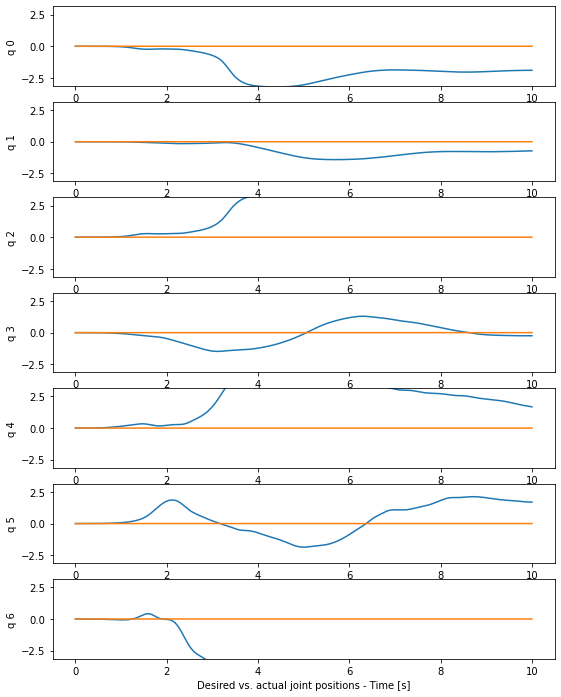

In [78]:
# we plot the simulated vs. actual position of the robot
plt.figure(figsize=[9, 12])
for i in range(7):
    plt.subplot(7, 1, i + 1)
    plt.plot(save_t, save_joint_positions[i, :])
    plt.plot(save_t, save_des_joint_positions[i, :])
    plt.ylim([-np.pi, np.pi])
    plt.ylabel(f"q {i}")
plt.xlabel("Desired vs. actual joint positions - Time [s]")


Text(0.5, 0, 'Desired vs. actual joint velocities - Time [s]')

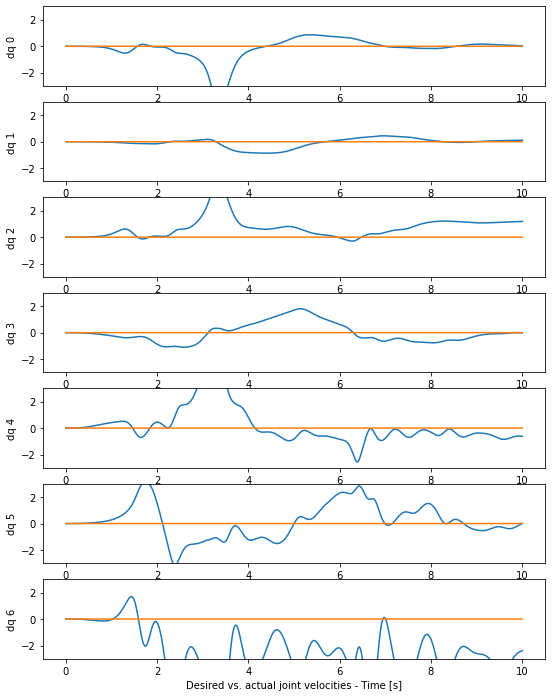

In [79]:
# we plot the simulated vs. actual position of the robot
plt.figure(figsize=[9, 12])
for i in range(7):
    plt.subplot(7, 1, i + 1)
    plt.plot(save_t, save_joint_velocities[i, :])
    plt.plot(save_t, save_des_joint_velocities[i, :])
    plt.ylim([-3, 3])
    plt.ylabel(f"dq {i}")
plt.xlabel("Desired vs. actual joint velocities - Time [s]")
